# eQTL Analysis

In [20]:
import copy
import glob
import os
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
import socket
if socket.gethostname() == 'fl1':
    pbt.set_tempdir('/projects/cdeboever/pybedtools_temp')

In [3]:
outdir = os.path.join(ciepy.root, 'output',
                      'eqtl_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'eqtl_analysis')
cpy.makedir(private_outdir)

In [4]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)

gold_eqtls = pd.read_table(
    os.path.join(ciepy.root, 'output', 'eqtl_methods_exploration', 'gold_eqtls.tsv'),
    index_col=0)

## Summary

In [55]:
print('We detected eQTLs for {:,} of {:,} genes tested.'.format(qvalues.sig.sum(), 
                                                                qvalues.shape[0]))

We detected eQTLs for 5,417 of 19,749 genes tested.


## Comparison to GTEx Multi-Tissue eQTLs

I want to visualize some of the permutation $p$-values versus the "real" $p$-value
for some of the GTEx multi-tissue eQTLs.

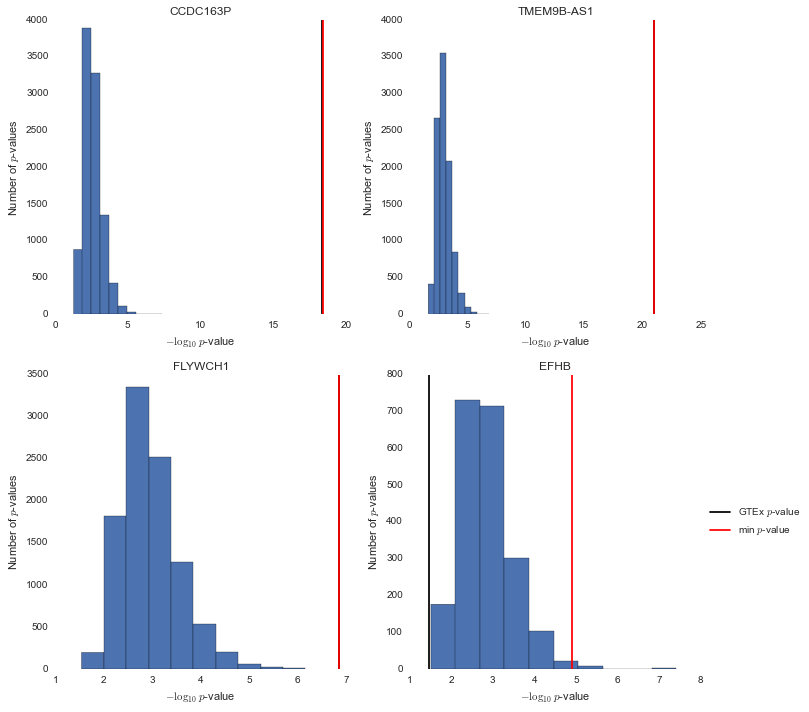

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, g in enumerate(gold_eqtls.index[1:5]):
    ax = axs[i]
    fn = os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 'results',
                      g, '{}.tsv'.format(g))
    min_fn = os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 'results', 
                          g, 'minimum_pvalues.tsv')
    if os.path.exists(min_fn):
        res = ciepy.read_emmax_output(fn)
        #t = res[res.MARKER_ID.apply(lambda x: gold_eqtls.ix[g, 'rsid'] in x)]
        t = res[res.BEG == gold_eqtls.ix[g, 'start']]
        min_pvals = pd.read_table(min_fn, header=None, squeeze=True)
        
        ax = (-np.log10(min_pvals)).hist(ax=ax)
        ax.set_ylabel('Number of $p$-values')
        ax.set_xlabel('$-\log_{10}$ $p$-value')
        ya, yb = ax.get_ylim()
        ax.vlines(-np.log10(t.PVALUE), ya, yb, label='GTEx $p$-value')
        ax.vlines(-np.log10(res.PVALUE.min()), ya, yb, colors=['red'], label='min $p$-value')
        ax.set_title('{}'.format(gene_info.ix[g, 'gene_name']));
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'gtex_comparison.pdf'), 
            bbox_extra_artists=(lgd,), bbox_inches='tight')

The black line shows the $p$-value for the GTEx SNV. The red line shows the smallest $p$-value that
I observe for the gene. We can see that most of these genes are highly significant compared to the 
permutation $p$-values.

## Distance to Nearest TSS

I may want to clean this analysis up a bit. Currently, some genes have more than 
one "most significant" eQTN.

I want to define one "most significant" QTN per gene. I'll choose the one closest to 
a TSS.

In [6]:
tss = pbt.BedTool(cpy.gencode_tss_bed)

In [7]:
s = '\n'.join(most_sig.chrom + '\t' + (most_sig.coord - 1).astype(str) + 
     '\t' + most_sig.coord.astype(str) + '\t' + most_sig.gene) + '\n'
bt = pbt.BedTool(s, from_string=True)
bt = bt.sort()

In [8]:
res = bt.closest(tss, D='b', sorted=True)

In [9]:
most_sig['tss_dist'] = np.nan
most_sig['tss_gene'] = ''
most_sig['tss_transcript'] = ''
most_sig['tss'] = ''
most_sig['tss_chrom'] = ''
most_sig['tss_start'] = 0
most_sig['tss_end'] = 0
most_sig['tss_strand'] = ''

most_sig_single = {}
for r in res:
    t = most_sig_single.get(r.name, copy.deepcopy(most_sig.ix[r.name]))
    if type(t) == pd.Series:
        if np.isnan(t['tss_dist']) or abs(int(r.fields[-1])) < abs(t['tss_dist']):
            t['tss_dist'] = int(r.fields[-1])
            t['tss_gene'] = tg[r.fields[-4].split('_')[0]]
            t['tss_transcript'] = r.fields[-4].split('_')[0]
            t['tss'] = '{}:{}-{}'.format(r.fields[-7], r.fields[-6], r.fields[-5])
            t['tss_chrom'] = r.fields[-7]
            t['tss_start'] = int(r.fields[-6])
            t['tss_end'] = int(r.fields[-5])
            t['tss_strand'] = r.fields[-2]
        most_sig_single[r.name] = t
    else:
        t.index = t.chrom + ':' + t.coord.astype(str)
        ind = r.chrom + ':' + str(r.end)
        old_d = t.ix[ind, 'tss_dist']
        if np.isnan(old_d) or abs(int(r.fields[-1])) < old_d:
            t.ix[ind, 'tss_dist'] = int(r.fields[-1])
            t.ix[ind, 'tss_dist'] = int(r.fields[-1])
            t.ix[ind, 'tss_gene'] = tg[r.fields[-4].split('_')[0]]
            t.ix[ind, 'tss_transcript'] = r.fields[-4].split('_')[0]
            t.ix[ind, 'tss'] = '{}:{}-{}'.format(r.fields[-7], r.fields[-6], r.fields[-5])
            t.ix[ind, 'tss_chrom'] = r.fields[-7]
            t.ix[ind, 'tss_start'] = int(r.fields[-6])
            t.ix[ind, 'tss_end'] = int(r.fields[-5])
            t.ix[ind, 'tss_strand'] = r.fields[-2]
            most_sig_single[r.name] = t
            
rows = []
for k in most_sig_single.keys():
    t = most_sig_single[k]
    if type(t) == pd.Series:
        rows.append(t.values)
    else:
        rows.append(t[t.tss_dist.abs() == t.tss_dist.abs().min()].values[0])

most_sig_single = pd.DataFrame(rows, columns=most_sig.columns)
most_sig_single.index = most_sig_single.gene

most_sig_single['sig'] = qvalues.ix[most_sig_single.index, 'sig']
most_sig_single['emp_pvalue'] = qvalues.ix[most_sig_single.index, 'pvalue']
most_sig_single['emp_qvalue'] = qvalues.ix[most_sig_single.index, 'qvalue']

sig_single = most_sig_single[most_sig_single.sig]

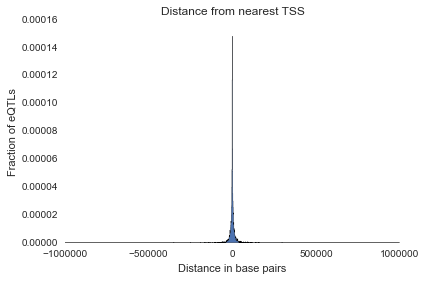

In [10]:
n,b,p = plt.hist(most_sig_single[most_sig_single.sig].tss_dist, 
                 bins=np.arange(-1000000, 1001000, 1000),
                 normed=True, histtype='stepfilled')
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

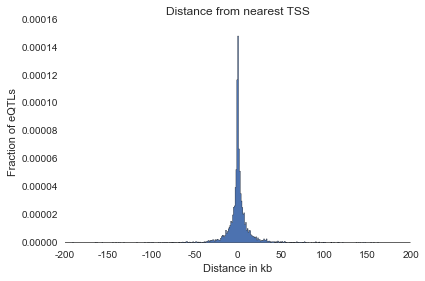

In [11]:
n,b,p = plt.hist(most_sig_single[most_sig_single.sig].tss_dist, 
                 bins=np.arange(-200000, 201000, 1000),
                 normed=True, histtype='stepfilled')
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in kb')
x = plt.xticks()
plt.xticks(x[0], [int(t) for t in x[0] / 1000])
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_snv_tss_dist.pdf'))

The above two plots are the same data at different $x$-axis limits. The first plot
in particular is meant to be comparable to Fig. S9 from the GTEx paper.

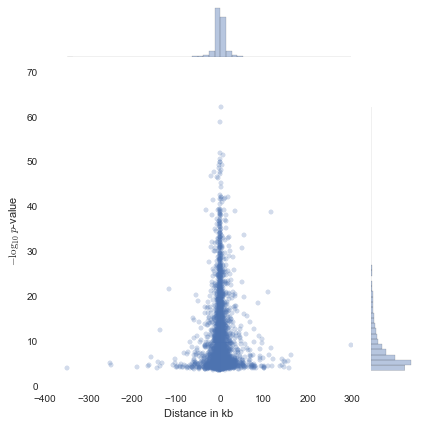

In [12]:
ax = sns.jointplot(most_sig_single[most_sig_single.sig].tss_dist / 1000,
                   -np.log10(most_sig_single[most_sig_single.sig].pvalue),
                   stat_func=None, alpha=0.25)
ax.set_axis_labels(xlabel='Distance in kb',
                   ylabel='$-\log_{10}$ $p$-value')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_pvalue_tss_dist.pdf'))

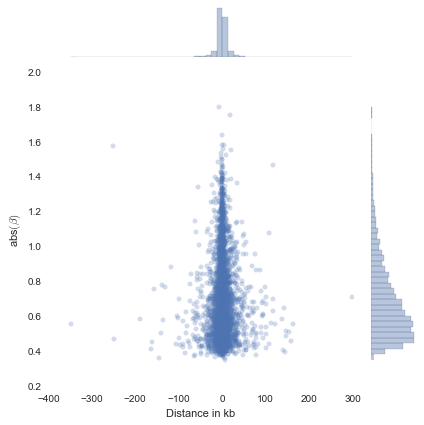

In [13]:
ax = sns.jointplot(most_sig_single[most_sig_single.sig].tss_dist / 1000,
                   most_sig_single[most_sig_single.sig].beta.abs(),
                   stat_func=None, alpha=0.25)
ax.set_axis_labels(xlabel='Distance in kb', ylabel='abs$(\\beta)$')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_beta_tss_dist.pdf'))

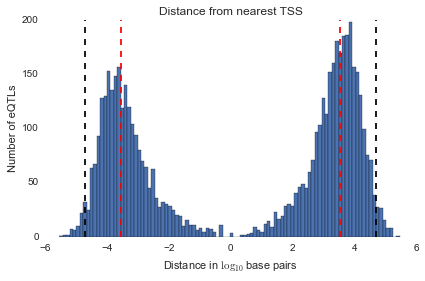

In [14]:
dists = most_sig_single[most_sig_single.sig].tss_dist
a = dists[dists >= 0]
b = -dists[dists < 0]
r = plt.hist(list(np.log10(a + 1)) + list(-np.log10(b + 1)),
             bins=100)
plt.title('Distance from nearest TSS')
plt.ylabel('Number of eQTLs')
plt.xlabel('Distance in $\log_{10}$ base pairs')
ya, yb = plt.ylim()
plt.vlines(np.log10(50000), ya, yb, linestyles='--')
plt.vlines(-np.log10(50000), ya, yb, linestyles='--')
plt.vlines(np.log10(3500), ya, yb, linestyles='--', color='red')
plt.vlines(-np.log10(3500), ya, yb, linestyles='--', color='red')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'sig_snv_tss_log_dist.pdf'))

In [52]:
t = most_sig_single[most_sig_single.sig]
print('{:,} of {:,} SNVs are closest to the TSS of their eQTL gene'.format(
        sum(t.index == t.tss_gene), t.shape[0]))

2,020 of 5,417 SNVs are closest to the TSS of their eQTL gene


Grubert et al. defined distal as greater than 50 kb away (outside of the black lines above). 
They searched for *cis* QTLs within 2kb of peak boundaries or $\pm$3.5kb around the TSS (inside
of the red lines above). I'd like to go back and see what they thought about the intermediate region.

I'm somewhat surprised that there are more potential QTNs downstream of TSSs. In the plot, a positive 
distance indicates that the SNV is downstream of the TSS (relative to the strand of the TSS). However,
only about half of the SNVs are actually closest to the TSS of their eQTL gene. It may be the
case that this distribution would look a little different if I found the closest TSS for the eQTL
gene.

## Manhattan and Expression Plots

In [15]:
fn = ('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/'
      'private_data/wgs/biallelic_snvs.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)
res_fns = glob.glob(os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 'results', 
                                 '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

sig = qvalues[qvalues.sig]
sig = sig.sort('qvalue')

In [16]:
def eqtl_summary(g, left=None, right=None, fn_root=None):
    res = ciepy.read_emmax_output(res_fns[g])
    res = res.sort('PVALUE')
    if gene_info.ix[most_sig_single.ix[g, 'gene'], 'strand'] == '+':
        gene_left = gene_info.ix[most_sig_single.ix[g, 'gene'], 'start']
        gene_right = gene_info.ix[most_sig_single.ix[g, 'gene'], 'end']
    else:
        gene_right = gene_info.ix[most_sig_single.ix[g, 'gene'], 'start']
        gene_left = gene_info.ix[most_sig_single.ix[g, 'gene'], 'end']
    if left:
        res = res[res.BEG >= gene_left - left]
    if right:
        res = res[res.BEG <= gene_right + right]
    plt.figure()
    plt.scatter(res.BEG, -np.log10(res.PVALUE), color='grey', alpha=0.5)
    plt.xlim(res.BEG.min(), res.BEG.max())
    ya = 0
    yb = (-np.log10(res.PVALUE)).max() + 1
    plt.ylim(ya, yb)
    plt.vlines(most_sig_single.ix[g, 'tss_start'], ya, yb, color='blue',
               linestyles='--', alpha=0.5)
    poly = plt.Polygon([[gene_left, 0.9 * yb], [gene_left, yb], [gene_right, 0.95 * yb]], 
                       closed=True, facecolor='blue', edgecolor='none')
    plt.gca().add_patch(poly)
    most_sig_single.ix[g, 'tss_start']
    plt.xlabel('Genomic position')
    plt.ylabel('$-\log_{10}$ $p$-value')
    plt.title('Manhattan plot for {}'.format(gene_info.ix[g, 'gene_name']));
    if fn_root:
        plt.tight_layout()
        plt.savefig('{}_manhattan.pdf'.format(fn_root))
        
    t =  vcf_reader.fetch('chr{}'.format(res.CHROM.values[0]), 
                          res.BEG.values[0], res.BEG.values[0] + 1)
    r = t.next()
    tdf = pd.DataFrame(exp.ix[g])
    tdf.columns = ['expression']
    tdf['genotype'] = 0
    hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
    tdf.ix[hets, 'genotype'] = 1
    alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
    tdf.ix[alts, 'genotype'] = 2
    plt.figure()
    #sns.lmplot(x='genotype', y='expression', data=tdf)
    ax = sns.violinplot(x='genotype', y='expression', data=tdf, color='grey',
                    order=[0, 1, 2], scale='count')
    sns.regplot(x='genotype', y='expression', data=tdf, scatter=False, color='red')
    ya, yb = plt.ylim()
    plt.text(0, yb, 'n={}'.format(sum(tdf.genotype == 0)), 
             verticalalignment='top', horizontalalignment='center')
    plt.text(1, yb, 'n={}'.format(sum(tdf.genotype == 1)), 
             verticalalignment='top', horizontalalignment='center')
    plt.text(2, yb, 'n={}'.format(sum(tdf.genotype == 2)), 
             verticalalignment='top', horizontalalignment='center')
    plt.title('Expression vs. genotype for {}'.format(gene_info.ix[g, 'gene_name']));
    if fn_root:
        plt.tight_layout()
        plt.savefig('{}_violin.pdf'.format(fn_root))

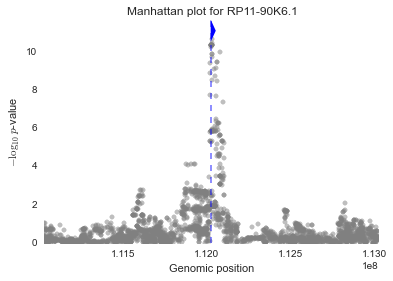

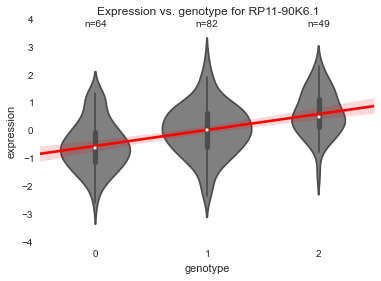

In [17]:
eqtl_summary(sig.index[0])

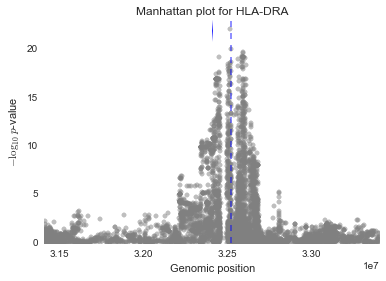

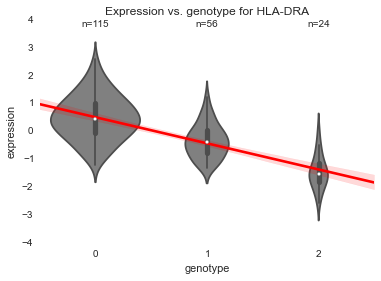

In [18]:
eqtl_summary(sig.index[5])

## GO Term Enrichment

In [26]:
go_results = cpb.analysis.goseq_gene_enrichment([x.split('.')[0] for x in sig.index],
                                                sig.sig, length_correct=False)

Loading hg19 length data...
Fetching GO annotations...

For 1424 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...


In [27]:
go_results.head()

,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_pvalue_bh,under_represented_pvalue_bh
category,,,,,,,,
GO:0000002,1,1,5,5,mitochondrial genome maintenance,BP,1,1
GO:0000003,1,1,188,188,reproduction,BP,1,1
GO:0000010,1,1,1,1,trans-hexaprenyltranstransferase activity,MF,1,1
GO:0000012,1,1,4,4,single strand break repair,BP,1,1
GO:0000014,1,1,1,1,single-stranded DNA endodeoxyribonuclease acti...,MF,1,1


## Pluripotency Genes

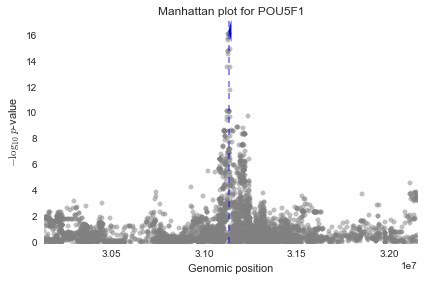

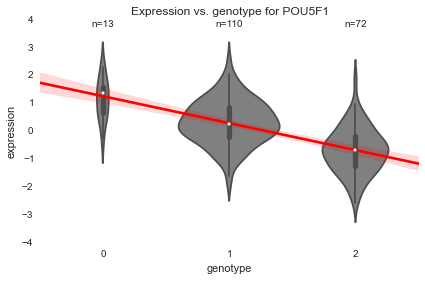

In [28]:
pgenes = ['LIN28A', 'POU5F1', 'SOX2', 'NANOG', 'MYC', 'KLF4']
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in sig.index:
        eqtl_summary(i, fn_root=os.path.join(outdir, '{}_summary'.format(g)))

In [29]:
def ld_vs_pval(g):
    fn = os.path.join(ciepy.root, 'private_data', 'wgs', 'ld.bed.gz')
    c = '{}/tabix {} {}:{}-{}'.format(cpy.htslib, fn, sig_single.ix[g].chrom,
                                      sig_single.ix[g].coord - 1, sig_single.ix[g].coord)
    res = subprocess.check_output(c, shell=True)
    tdf = pd.DataFrame([x.split() for x in res.strip().split('\n')],
                       columns=['chrom', 'start', 'end', 'name', 'ld'])
    tdf.index = tdf.name.apply(lambda x: x.split('-')[1])
    tdf = tdf.convert_objects(convert_numeric=True)

    res = ciepy.read_emmax_output(res_fns[g])
    res.index = 'chr' + res.CHROM.astype(str) + ':' + res.BEG.astype(str)
    plt.scatter(tdf.ld.values, -np.log10(res.ix[tdf.index, 'PVALUE'].values), 
                color='grey', alpha=0.5, s=100)
    xa, xb = plt.xlim()
    plt.hlines(-np.log10(sig_single.ix[g, 'pvalue']), xa, xb,
               color='red', linestyle='--')
    plt.ylabel('$-\log_{10}$ $p$-value')
    plt.xlabel('LD with most significant SNV');

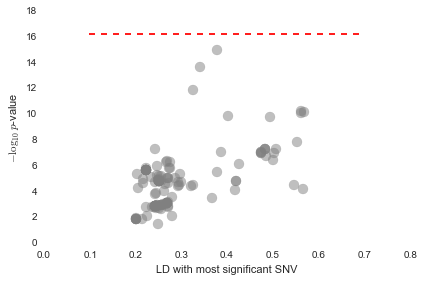

In [30]:
gid = gene_info[gene_info.gene_name == 'POU5F1'].index[0]
ld_vs_pval(gid)
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'POU5F1_top_snv_ld.pdf'))

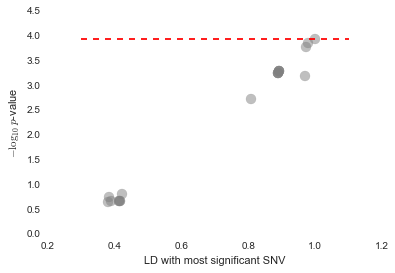

In [31]:
gid = sig_single.index[10]
ld_vs_pval(gid)

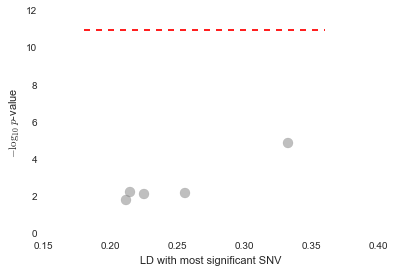

In [32]:
gid = sig_single.index[20]
ld_vs_pval(gid)

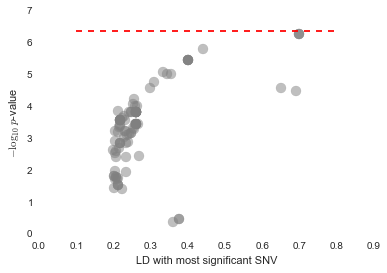

In [33]:
gid = sig_single.index[40]
ld_vs_pval(gid)

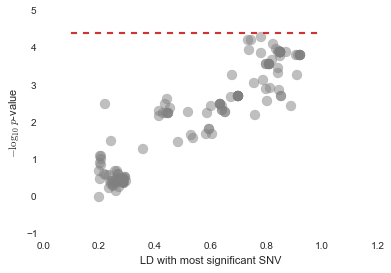

In [34]:
gid = sig_single.index[50]
ld_vs_pval(gid)

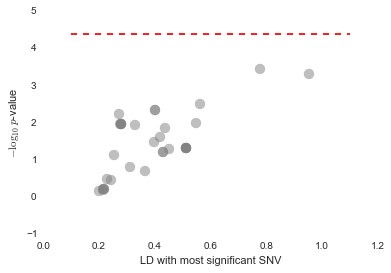

In [35]:
gid = sig_single.index[60]
ld_vs_pval(gid)

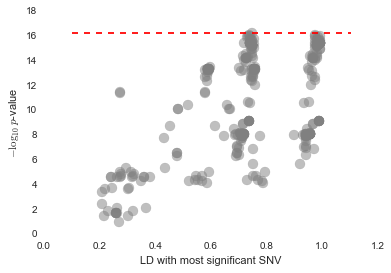

In [36]:
gid = sig_single.index[130]
ld_vs_pval(gid)

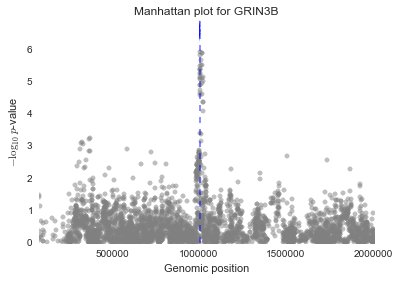

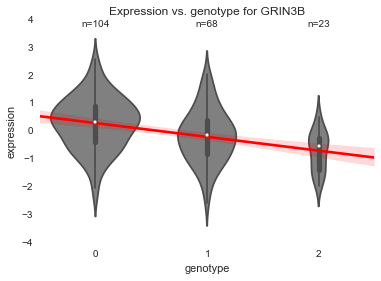

In [37]:
eqtl_summary(sig_single.index[0])

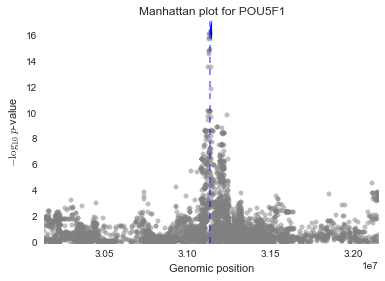

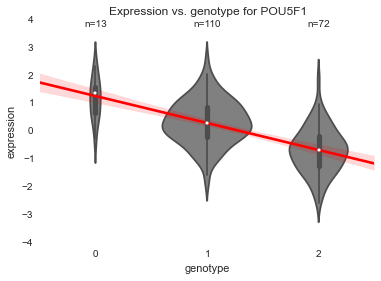

In [38]:
eqtl_summary(gene_info[gene_info.gene_name == 'POU5F1'].index[0])

In [39]:
gene_info[gene_info.gene_name == 'POU5F1']

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level
gene_id,,,,,,,,,
ENSG00000204531.11,POU5F1,protein_coding,chr6,31132118,31148508,-,KNOWN,HAVANA,1


In [40]:
sig_single.ix[gene_info[gene_info.gene_name == 'POU5F1'].index[0]]

chrom                               chr6
coord                           31135172
loc                        chr6:31135172
gene                  ENSG00000204531.11
marker_id                 6:31135172_T/A
ns                                   194
ac                                   254
callrate                         0.99487
genocnt                        12/110/72
maf                              0.34536
stat                             -9.2106
pvalue                         5.692e-17
beta                             -0.9792
sebeta                            0.1063
r2                                0.3064
tss_dist                            -225
tss_gene              ENSG00000204531.11
tss_transcript         ENST00000513407.1
tss               chr6:31134946-31134947
tss_chrom                           chr6
tss_start                       31134946
tss_end                         31134947
tss_strand                             -
sig                                 True
emp_pvalue      

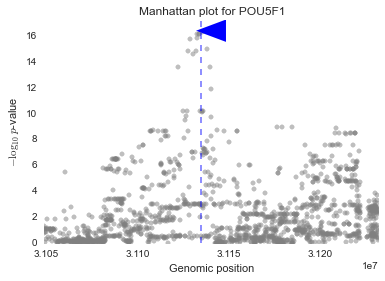

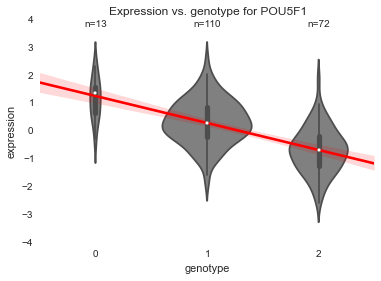

In [41]:
eqtl_summary(gene_info[gene_info.gene_name == 'POU5F1'].index[0], 
             left=100000, right=100000)

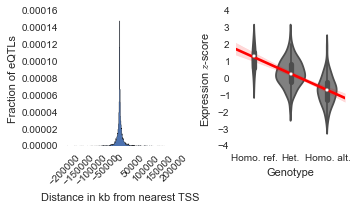

In [97]:
#def eqtl_summary(g, left=None, right=None, fn_root=None):
g = gene_info[gene_info.gene_name == 'POU5F1'].index[0]
res = ciepy.read_emmax_output(res_fns[g])
res = res.sort('PVALUE')

fig, axs = plt.subplots(1, 2, figsize=(5, 3))
axs = axs.flatten()
ax = axs[0]
n,b,p = ax.hist(most_sig_single[most_sig_single.sig].tss_dist, 
                bins=np.arange(-200000, 201000, 1000),
                normed=True, histtype='stepfilled')
#plt.title('Distance from nearest TSS')
ax.set_ylabel('Fraction of eQTLs')
ax.set_xlabel('Distance in kb from nearest TSS')
x = ax.get_xticks()
ax.set_xticks(x, [int(t) for t in x / 1000])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax = axs[1]
t =  vcf_reader.fetch('chr{}'.format(res.CHROM.values[0]), 
                      res.BEG.values[0], res.BEG.values[0] + 1)
r = t.next()
tdf = pd.DataFrame(exp.ix[g])
tdf.columns = ['expression']
tdf['genotype'] = 0
hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
tdf.ix[hets, 'genotype'] = 1
alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
tdf.ix[alts, 'genotype'] = 2
ax = sns.violinplot(x='genotype', y='expression', data=tdf, color='grey',
                order=[0, 1, 2], scale='count', ax=ax)
sns.regplot(x='genotype', y='expression', data=tdf, scatter=False, color='red', ax=ax)
ax.set_xticklabels(['Homo. ref.', 'Het.', 'Homo. alt.'])
ax.set_ylabel('Expression $z$-score')
ax.set_xlabel('Genotype')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'tss_dist_pou5f1.png'), dpi=600)